In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
images = []
ages = []
genders = []

for i in os.listdir('/Users/diassss/Desktop/amlfinal/archive/crop_part1')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    # Use os.path.join to concatenate directory and file name
    file_path = os.path.join('/Users/diassss/Desktop/amlfinal/archive/crop_part1', i)
    # Open the image and append to the list, ensuring it gets closed
    with Image.open(file_path) as img:
        images.append(np.array(img))


In [4]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df


,Images,Ages,Genders
0,"[[[93, 107, 74], [90, 104, 71], [87, 101, 68],...",9,1
1,"[[[97, 63, 53], [95, 61, 49], [91, 57, 45], [8...",1,1
2,"[[[13, 5, 2], [16, 8, 5], [17, 9, 6], [16, 8, ...",16,0
3,"[[[84, 55, 37], [85, 56, 38], [89, 58, 40], [9...",1,1
4,"[[[25, 24, 20], [22, 21, 17], [20, 19, 15], [2...",26,1
...,...,...,...
7995,"[[[49, 45, 46], [54, 50, 51], [60, 56, 57], [6...",48,0
7996,"[[[195, 181, 146], [186, 171, 138], [175, 162,...",65,0
7997,"[[[129, 86, 41], [127, 84, 39], [126, 83, 38],...",5,1
7998,"[[[4, 13, 42], [2, 12, 39], [0, 9, 36], [1, 8,...",35,0


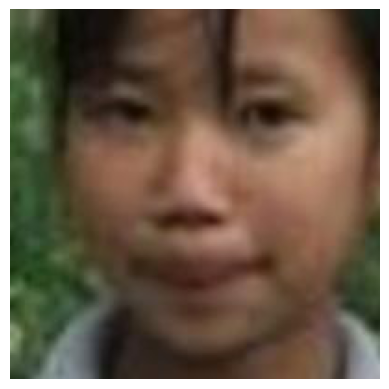

Age: 9
Gender: 1


In [5]:
import matplotlib.pyplot as plt

# Display the image from the DataFrame
plt.imshow(df['Images'][0])
plt.axis('off')  # Turn off axes for better visualization
plt.show()

# Print age and gender
print("Age:", df['Ages'][0])
print("Gender:", df['Genders'][0])


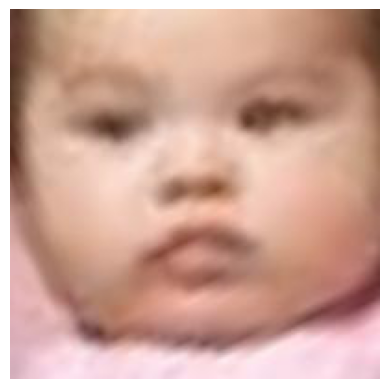

Age: 1
Gender: 1


In [6]:
plt.imshow(df['Images'][1])  
plt.axis('off')
plt.show()
print("Age:", df['Ages'][1])
print("Gender:", df['Genders'][1])

/var/folders/vf/klpnm2mj78s1z1555ql7vsr40000gn/T/ipykernel_10283/409036286.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)


<Axes: xlabel='Ages', ylabel='Density'>

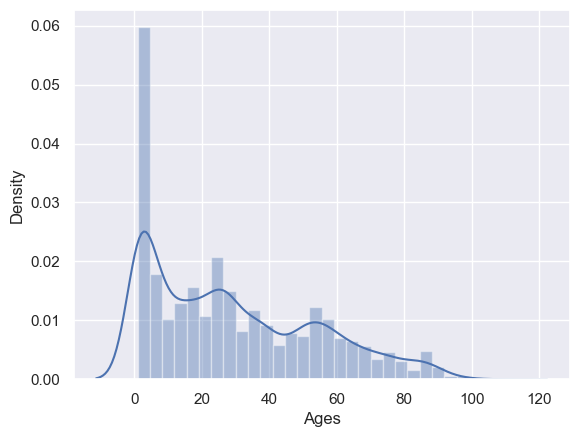

In [7]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [8]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)


/var/folders/vf/klpnm2mj78s1z1555ql7vsr40000gn/T/ipykernel_10283/1853336140.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)


<Axes: xlabel='Ages', ylabel='Density'>

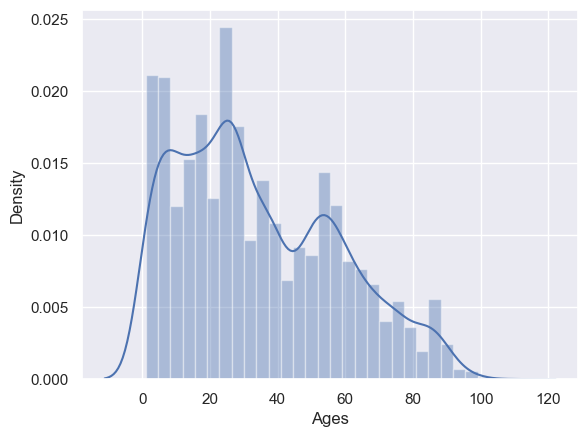

In [9]:
sns.distplot(df['Ages'],kde=True, bins=30)


In [10]:
df = df[df['Ages'] < 80]

/var/folders/vf/klpnm2mj78s1z1555ql7vsr40000gn/T/ipykernel_10283/2749225890.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=20)


<Axes: xlabel='Ages', ylabel='Density'>

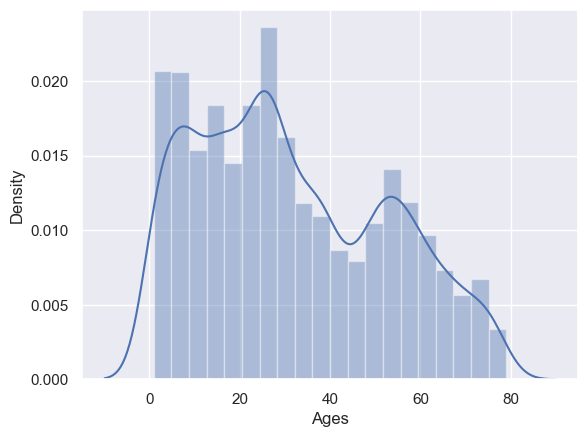

In [11]:
sns.distplot(df['Ages'],kde=True, bins=20)

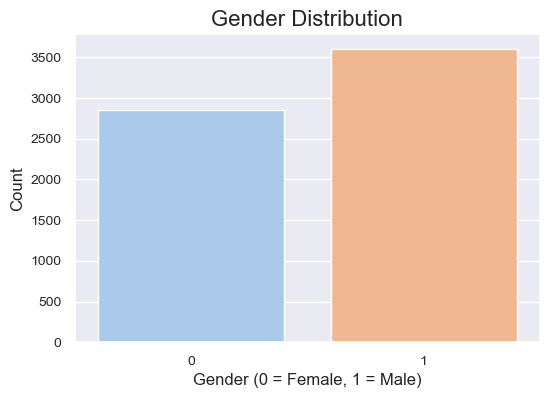

In [12]:
plt.figure(figsize=(6, 4))  # Adjust figure size for better readability
sns.countplot(x=df['Genders'], palette='pastel')  # Create the countplot
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender (0 = Female, 1 = Male)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [13]:
df = df[df['Genders'] != 3]

In [14]:
from PIL import Image

x = []
y = []

for i in range(len(df)):
    # Ensure the image is a PIL Image
    if not isinstance(df['Images'].iloc[i], Image.Image):
        img = Image.fromarray(df['Images'].iloc[i])  # Convert array back to PIL Image
    else:
        img = df['Images'].iloc[i]
    
    # Resize the image using LANCZOS (instead of ANTIALIAS)
    resized_img = img.resize((200, 200), Image.Resampling.LANCZOS)
    
    # Convert the resized image to a numpy array
    ar = np.asarray(resized_img)
    x.append(ar)
    
    # Prepare age and gender labels
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)

# Convert to numpy arrays
x = np.array(x)
y = np.array(y)


In [15]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)


In [16]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(learning_rate=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

/Users/diassss/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-18 21:35:35.426664: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-18 21:35:35.426768: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-18 21:35:35.426787: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-18 21:35:35.426821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-18 21:35:35.426855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:

In [17]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

Epoch 1/50


2024-11-18 21:36:52.346561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/diassss/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - loss: 679.3721 - val_loss: 444.7487
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - loss: 483.1440 - val_loss: 395.0051
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - loss: 420.5218 - val_loss: 316.1628
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - loss: 370.0274 - val_loss: 298.6427
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - loss: 351.5562 - val_loss: 299.3716
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - loss: 348.8618 - val_loss: 277.8340
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - loss: 333.9375 - val_loss: 284.7423
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - loss: 331.6130 - val_loss: 264.0344
Epoch 9/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - loss: 328.3511 - val_loss: 278.3782
Epoch 10/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step - loss: 315.2115 - val_loss: 254.8671
Epoch 11/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 30s 177ms/step - loss: 315.7456 - val_l

In [19]:
agemodel.save('age_model.keras')
print("Модель для возраста успешно сохранена как 'age_model.h5'")

Модель для возраста успешно сохранена как 'age_model.h5'


In [20]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=40, shuffle=True, validation_data=test2)

Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.5896 - loss: 0.6728 - val_accuracy: 0.6762 - val_loss: 0.6090
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - accuracy: 0.6839 - loss: 0.6053 - val_accuracy: 0.7080 - val_loss: 0.5818
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 0.6964 - loss: 0.5783 - val_accuracy: 0.7343 - val_loss: 0.5101
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.7284 - loss: 0.5466 - val_accuracy: 0.7576 - val_loss: 0.4886
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/step - accuracy: 0.7338 - loss: 0.5314 - val_accuracy: 0.7761 - val_loss: 0.4700
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 319ms/step - accuracy: 0.7508 - loss: 0.5040 - val_accuracy: 0.7885 - val_loss: 0.4475
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - accuracy: 0.7803 - loss: 0.4804 - val_accuracy: 0.7854 - val_loss: 0.4458
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 328ms/step - accuracy: 0.7821 - loss: 0.4641 - val_accu

In [21]:
genmodel.save('gender_model.keras')
print("Модель для пола успешно сохранена как 'gender_model.keras'")


Модель для пола успешно сохранена как 'gender_model.keras'


In [22]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.Resampling.LANCZOS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.Resampling.LANCZOS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.Resampling.LANCZOS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.Resampling.LANCZOS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Age: 15 
 Gender: male


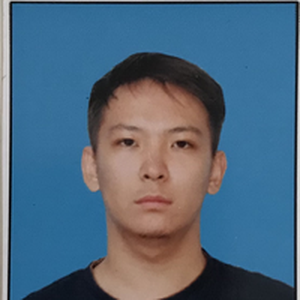

In [23]:
process_and_predict('/Users/diassss/Downloads/IMG_8543.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Age: 49 
 Gender: male


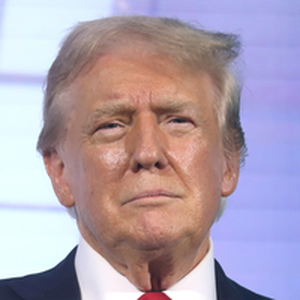

In [24]:
process_and_predict('/Users/diassss/Downloads/Donald_Trump_(53911672914)_(cropped).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Age: 41 
 Gender: female


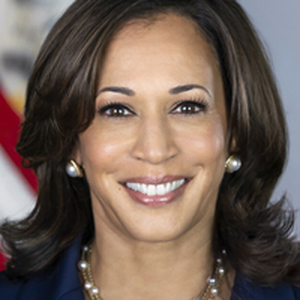

In [25]:
process_and_predict('/Users/diassss/Downloads/Без названия (1).jpeg')